<center><h1>Support Vector Machine (Машина Опорных Векторов)</h1></center>

Импорт необходимых библиотек перед переходом к ноутбуку:

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from mpl_toolkits import mplot3d
from sklearn import svm
from sklearn.datasets import make_circles, make_classification
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score,
    f1_score,
    mean_squared_error,
    precision_score,
    recall_score,
    roc_auc_score,
)
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from tqdm import tqdm_notebook

plt.style.use("ggplot")

import warnings

warnings.filterwarnings("ignore")

# Hard-Margin SVM

У нас есть:

$y \in \{-1, +1\}$

$x \in R^d$

$\big\{ (x_i, y_i) \big\}_{i=1}^{n}$

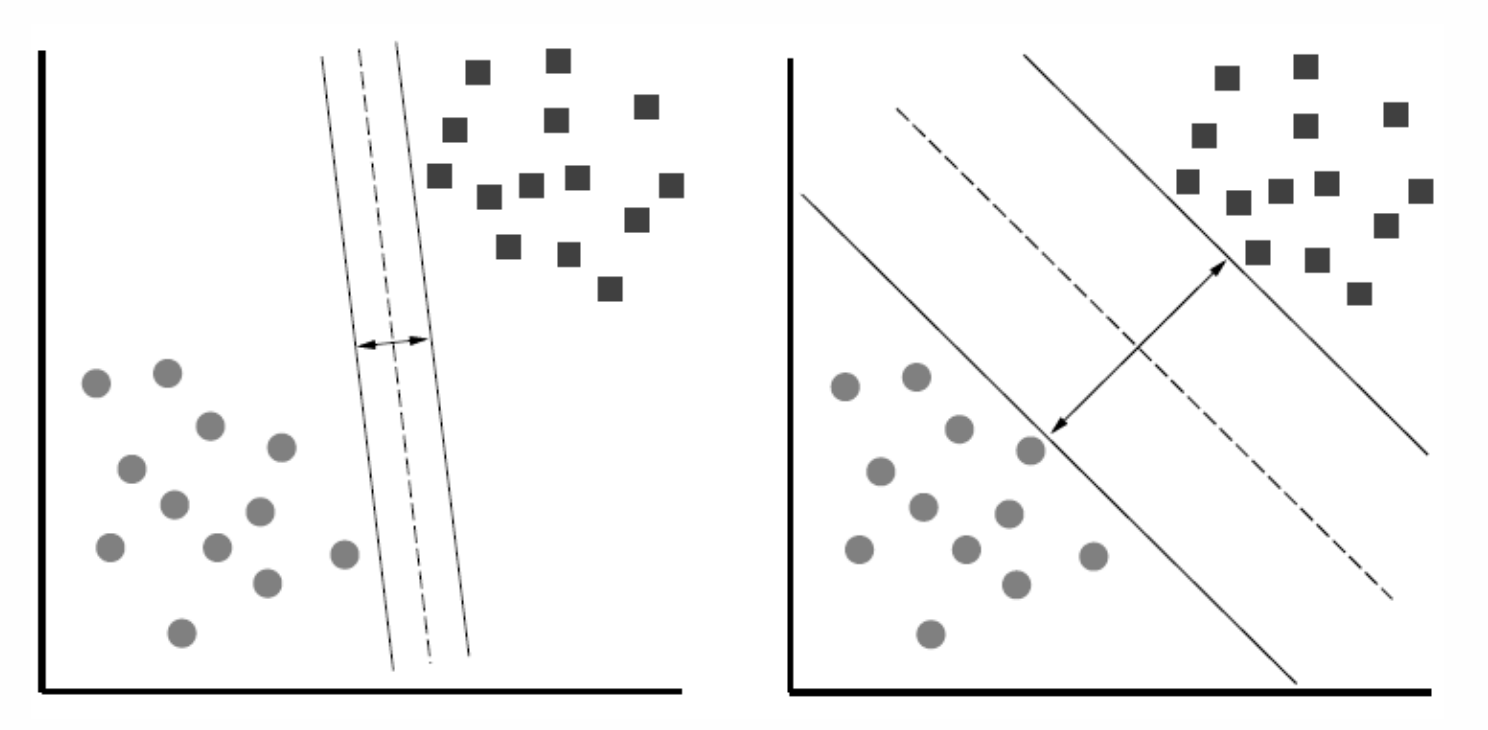

**Напоминание из ЛинАла и АнГема:**

Уравнение гиперплоскости:

$$w^T x + w_0 = 0$$

Свойства:

1) Две точки на гиперплоскости $x_1$, $x_2$

$$w^T x_1 + w_0 = w^T x_2 + w_0 = 0$$

$$w^T (x_1 - x_2) = 0$$

$$w^T \perp (x_1 - x_2)$$

2) $\forall x$

$$w^T x + w_0 = 0$$

$$w_0 = - w^T x$$

3) Расстояние от точки до прямой:

3.1) $A B = ||A|| \, ||B|| \, cos(\alpha)$, где $A$ и $B$ - вектора и $\alpha$ - угол между ними

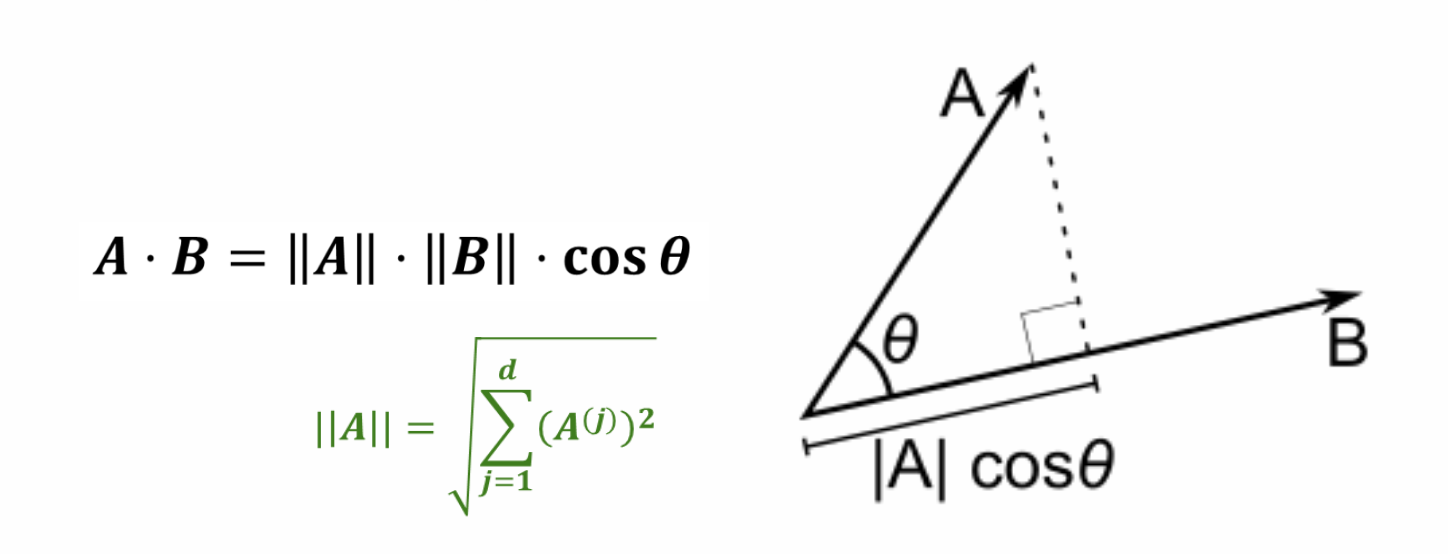

Отсюда: $\forall x_0$

$$\frac{w^T (x - x_0)}{||w||} = \frac{w^T x - w^T x_0}{||w||} = \frac{w^T x + w_0}{||w||} = d$$

## Формулируем Hard-Margin SVM

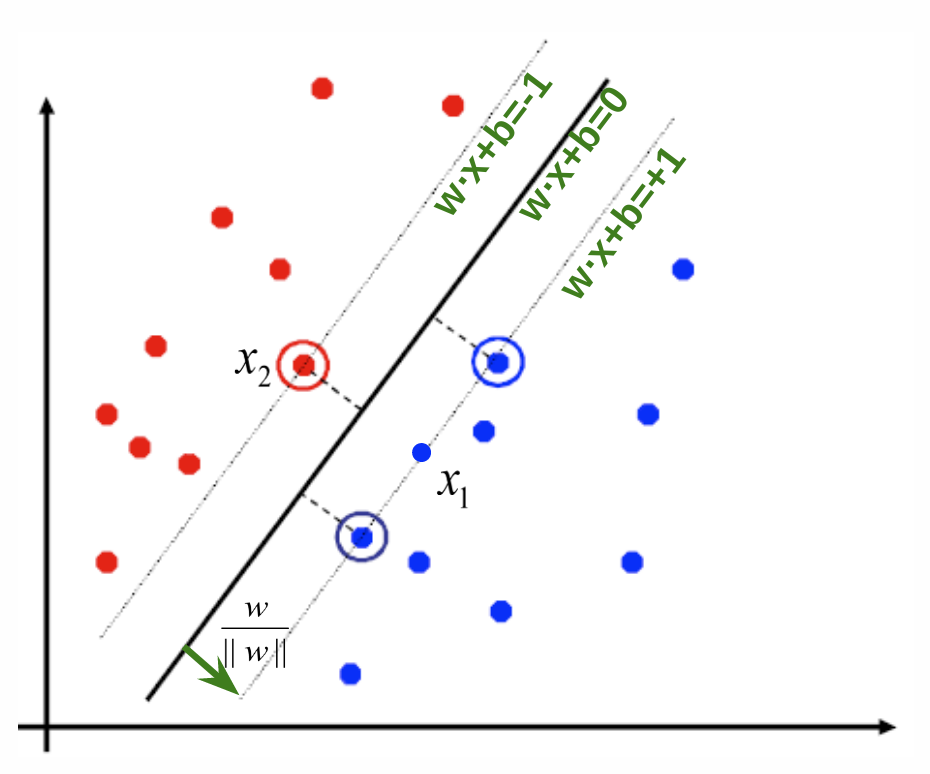

Расстояние до любого $x_i$ $\implies$ $d_i \, y_i$

$d_i = \frac{w^T x_i + w_0}{||w||}$

Отступ (margin):&emsp; $\gamma = \min_i \big( d_i \, y_i \big) = \min_i \big( \frac{y_i (w^T x_i + w_0)}{||w||} \big)$

Тогда $\forall x_i$, который не находится на заданной гиперплоскости:

$$y_i (w^T x_i + w_0) > 0$$

$$y_i (w^T x_i + w_0) \geq C$$

$$y_i (\frac{w^T}{C} x_i + \frac{w_0}{C}) \geq 1$$

$$y_i (w'^T x_i + w'_0) \geq 1$$

Тогда числитель MARGIN - это как минимум 1. Следовательно, можем заменить:

$$\gamma = \min_i \big( \frac{1}{||w||} \big)$$

**Задача максимизации отступа (margin) для Hard-Margin SVM:**

$\max_{w} \gamma \approx \max_{w} \frac{1}{||w||} \approx \min_{w} ||w|| \approx \min_{w} \frac{1}{2} ||w||^2$

&emsp;&emsp; $\min_{w} \frac{1}{2} ||w||^2$

&emsp;&emsp; $\forall{i} \;\; y_i(w^T x_i + w_0) \geq 1$

Нас интересуют точки, которые лежат на отступе:

&emsp;&emsp; $\min_{w} \frac{1}{2} ||w||^2$

&emsp;&emsp; $\forall{i} \;\; y_i(w^T x_i + w_0) = 1$

# Soft-Margin SVM

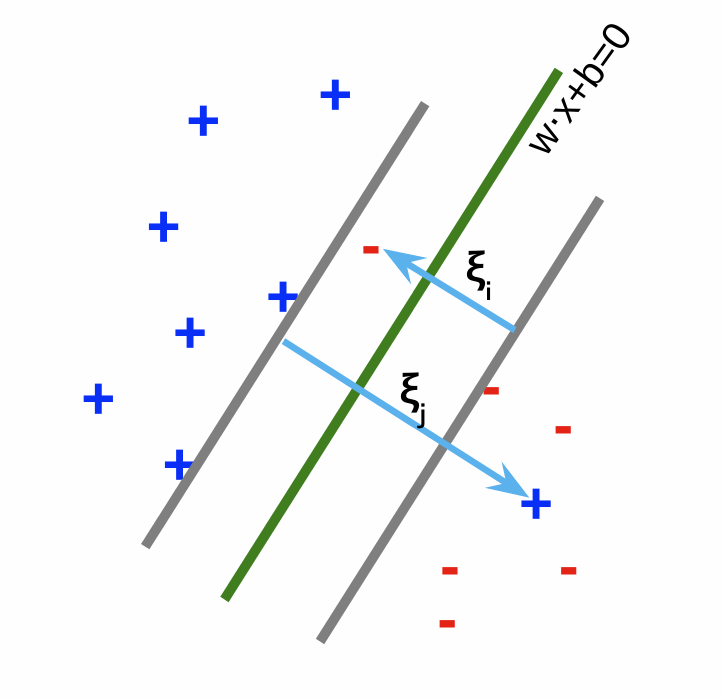

**Задача максимизации отступа (margin) для Soft-Margin SVM:**

&emsp;&emsp; $\min_{w} \big[ \frac{1}{2} ||w||^2 + C \displaystyle\sum_{i=1}^{n} \xi \big]$

&emsp;&emsp; $\forall{i} \;\; y_i(w^T x_i + w_0) \geq 1 - \xi$

&emsp;&emsp; $\xi \geq 0$

#### SVM:

Еще раз вспомним нашу задачу, которую мы пытаемся решить, используя методы оптимизации:

&emsp;&emsp; $\min_{w} \big[ \frac{1}{2} ||w||^2 + C \displaystyle\sum_{i=1}^{n} \xi \big]$

&emsp;&emsp; $\forall{i} \;\; y_i(w^T x_i + w_0) \geq 1 - \xi$

&emsp;&emsp; $\xi \geq 0$

Переформулируем ее в терминах **Hinge Loss**:

Hinge Loss: $HL(z) = max(0, 1-z)$

&emsp;&emsp; $argmin_{w} \big[ \frac{1}{2} ||w||^2 + C \displaystyle\sum_{i=1}^{n} \max\{ 0, 1 - y_i(w^T x_i + w_0) \} \big]$

### Как можно найти оптимальное решение представленной задачи?

**Градиентный спуск!**

Давайте найдем производную для нашей функции потерь:

$L = \frac{1}{2} ||w||^2 + С \displaystyle\sum_{i=1}^{n} \max\{ 0, 1 - y_i w^T x_i) \}$

$\frac{dL}{dw} = \begin{cases}
    w       & \quad \text{if}\;\;\; y_i \, w^T \, x_i \geq 1\\
    w - C \, y_i \, x_{i}  & \quad \text{else}
\end{cases}$

Вспомним формулу градиентного спуска:&emsp; $w = w - \alpha \frac{dL}{dw}$

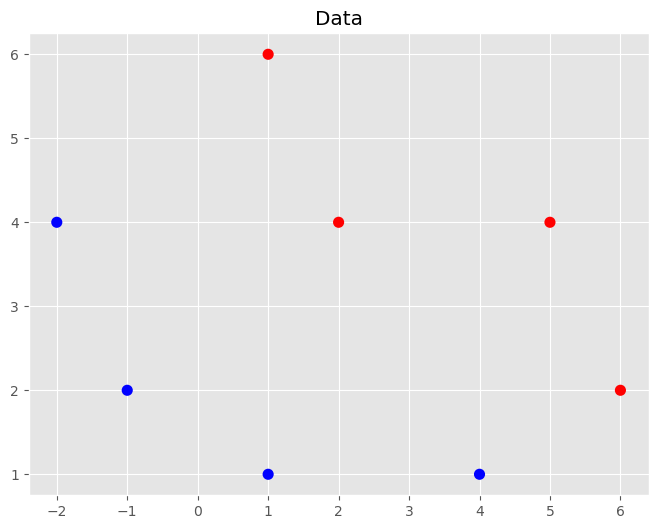

In [2]:
X = np.array(
    [
        [1, -2, 4],
        [1, 4, 1],
        [1, -1, 2],
        [1, 1, 1],
        [1, 1, 6],
        [1, 2, 4],
        [1, 6, 2],
        [1, 5, 4],
    ]
)

y = np.array([-1, -1, -1, -1, 1, 1, 1, 1])

plt.figure(figsize=(8, 6))
plt.title("Data")
plt.scatter(
    X[:, 1], X[:, 2], linewidths=2, c=["red" if col == 1 else "blue" for col in y]
)
plt.show()

In [3]:
def svm_sgd(X, Y):
    w = np.random.normal(size=len(X[0]))
    lr = 0.1
    n_epochs = 100000
    C = 10000

    for epoch in tqdm_notebook(
        range(1, n_epochs + 1)
    ):  # 1 эпоха - проход по всем данным
        for i, x in enumerate(
            X
        ):  # 1 итерация (в данном случае) - рассчет градиента для 1 точки

            # HingeLoss = max(0, y[i] x[i] w)
            HL = Y[i] * np.dot(X[i], w)  # Hinge Loss - часть максимума, кторая больше 0

            if HL < 1:
                w = w - lr * (1 / epoch) * (w - C * X[i] * Y[i])
            else:
                w = w - lr * (1 / epoch) * w

    return w

In [4]:
w = svm_sgd(X, y)

  0%|          | 0/100000 [00:00<?, ?it/s]

In [5]:
x_hyp = np.arange(-2, 7)
y_hyp = -(x_hyp * w[1] + w[0]) / w[2]

left_margin_y = (-1 - x_hyp * w[1] - w[0]) / w[2]
right_margin_y = (1 - x_hyp * w[1] - w[0]) / w[2]

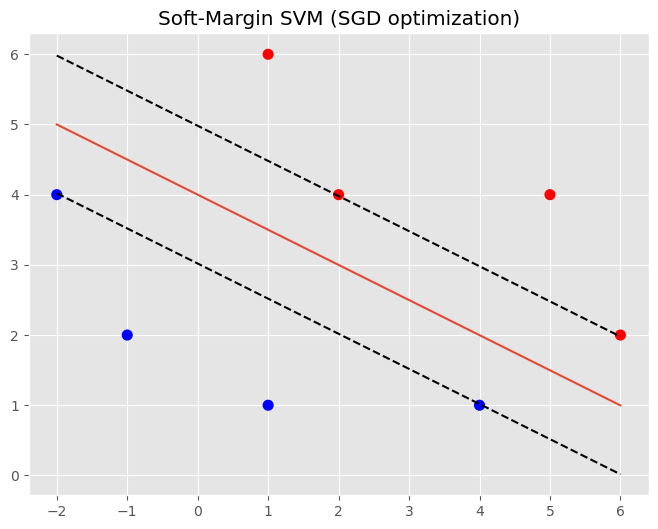

In [6]:
plt.figure(figsize=(8, 6))
plt.title("Soft-Margin SVM (SGD optimization)")
plt.scatter(
    X[:, 1], X[:, 2], linewidths=2, c=["red" if col == 1 else "blue" for col in y]
)
plt.plot(x_hyp, y_hyp)
plt.plot(x_hyp, left_margin_y, color="black", linestyle="--")
plt.plot(x_hyp, right_margin_y, color="black", linestyle="--")
plt.show();

# Итак, предварительный итог

### Два вида SVM

**Hard-Margin SVM**

&emsp;&emsp; $\min_{w} \frac{1}{2} ||w||^2$

&emsp;&emsp; $\forall{i} \;\; y_i(w^T x_i + w_0) \geq 1$

**Soft-Margin SVM**

&emsp;&emsp; $\min_{w} \big[ \frac{1}{2} ||w||^2 + C \displaystyle\sum_{i=1}^{n} \xi \big]$

&emsp;&emsp; $\forall{i} \;\; y_i(w^T x_i + w_0) \geq 1 - \xi$

&emsp;&emsp; $\xi \geq 0$

Оба случая - задачи квадратичной минимизации. Можем решить через Лагранджа. Можем переписать в терминах функции потерь и решить с помощью SGD.

### Посмотрим реализацию scikit - learn:

In [7]:
def plot_svc_log_decision_function(clf1, clf2, ax=None):
    if ax is None:
        ax = plt.gca()
    x = np.linspace(plt.xlim()[0], plt.xlim()[1], 30)
    y = np.linspace(plt.ylim()[0], plt.ylim()[1], 30)
    XX, YY = np.meshgrid(x, y)
    XY = np.c_[XX.ravel(), YY.ravel()]
    P1 = clf1.decision_function(XY)
    P1 = P1.reshape(XX.shape)

    P2 = clf2.decision_function(XY)
    P2 = P2.reshape(XX.shape)
    cplot = ax.contour(
        XX,
        YY,
        P1,
        colors="k",  # label='svm',
        levels=[-1, 0, 1],
        alpha=0.5,
        linestyles=["--", "-", "--"],
    )
    ax.clabel(cplot, inline=1, fontsize=10)

    ax.contour(
        XX,
        YY,
        P2,
        colors="r",  # label='logreg',
        levels=[0],
        alpha=0.5,
        linestyles=["-"],
    )


def plot_svc_decision_function(clf1, ax=None):
    if ax is None:
        ax = plt.gca()
    x = np.linspace(plt.xlim()[0], plt.xlim()[1], 30)
    y = np.linspace(plt.ylim()[0], plt.ylim()[1], 30)
    XX, YY = np.meshgrid(x, y)
    XY = np.c_[XX.ravel(), YY.ravel()]
    P1 = clf1.decision_function(XY)
    P1 = P1.reshape(XX.shape)

    cplot = ax.contour(
        XX,
        YY,
        P1,
        colors="k",  # label='svm',
        levels=[-1, 0, 1],
        alpha=0.5,
        linestyles=["--", "-", "--"],
    )
    ax.clabel(cplot, inline=1, fontsize=10)


def lin_sep_svm_demo(class_sep=2, random_state=30):
    X, y = make_classification(
        n_samples=100,
        n_features=2,
        n_informative=2,
        class_sep=class_sep,
        scale=1,
        n_redundant=0,
        n_clusters_per_class=1,
        random_state=random_state,
    )

    lin_svm = svm.SVC(kernel="linear", C=1).fit(X, y)

    log_reg = LogisticRegression(C=1).fit(X, y)

    plt.figure(figsize=(10, 7))
    plt.scatter(X[:, 0], X[:, 1], c=y, s=70, cmap="autumn")

    plot_svc_log_decision_function(lin_svm, log_reg)

    plt.xlabel("$x_1$")
    plt.ylabel("$x_2$")

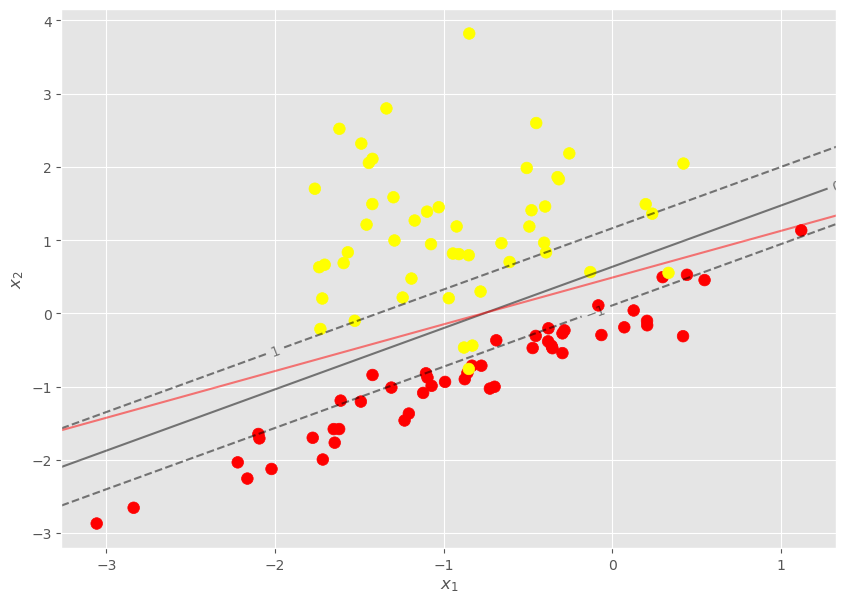

In [8]:
lin_sep_svm_demo(class_sep=1)

# Ядра (kernels) и спрямляющие пространства

Существуют такие функции K(x, y), что:

$$K(x, y) = \phi(x)^T \phi(y)$$

* $\phi: X \rightarrow H$
* $H$ - пространство большей размерности, в котором классы становятся линейноразделимыми, называется **спрямляющим**.
* Разделяющся гиперплоскость в таком пространстве будет линейной, но при проекции на исходное пространство $X$ - нет

Популярные ядра:

1. Линейное (linear): $$\langle x, y\rangle$$
2. Полиномиальное (polynomial): $$(\gamma \langle x, y\rangle + с)^d$$ 
3. Radial basis function kernel (rbf): $$e^{(-\gamma  \cdot \|x - y\|^2)}$$ 
4. Sigmoid: $$\tanh(\gamma \langle x,y \rangle + r)$$


Хорошую интерактивную визуализацию можно найти на [YouTube](https://www.youtube.com/watch?v=3liCbRZPrZA).


# Визуализации перехода в спрямляющая пространство

Пусть у нас есть точни на плоскости, причем они линейно нераздилимы и образуют два кластера: шар внутри кольца.

Передем из двумерного пространство в трехмерное, добавив координату по формуле по формуле: $z = x_1^2 + x_2^2$. 

В трехмерном пространстве данные уже можно разделить гиперплоскостью, которая при проекция на исходное 2D пространство даст в сечение окружность. Таким образом, мы получим нелинейную разделяющую границу, которая разделит классы.

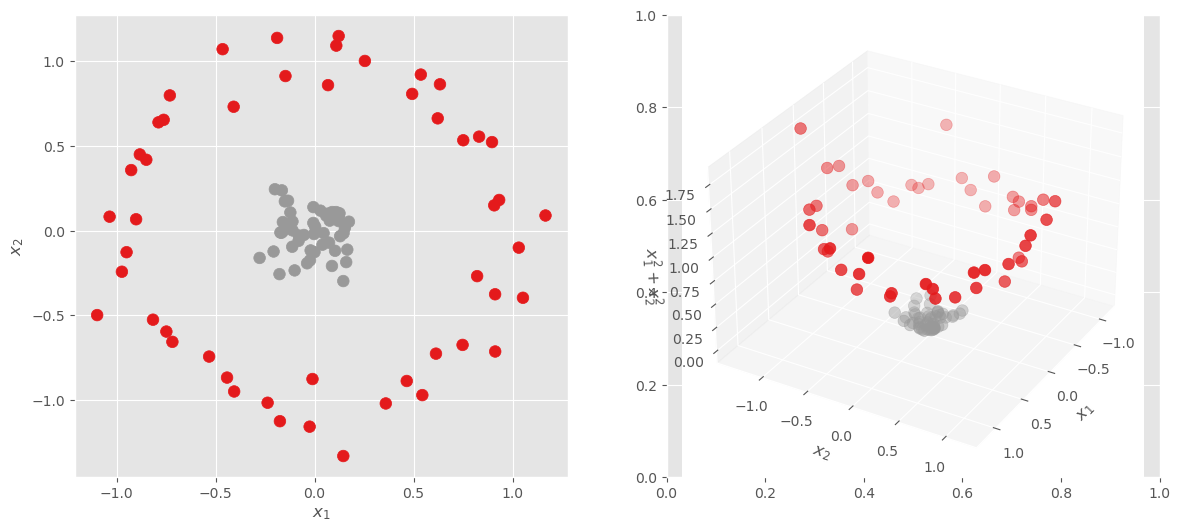

In [9]:
def demo_nonlin_data():
    X, y = make_circles(n_samples=100, factor=0.1, noise=0.1, random_state=0)

    fig = plt.figure(figsize=(14, 6))

    ax = fig.add_subplot(1, 2, 1)

    ax.scatter(X[:, 0], X[:, 1], c=y, s=70, cmap="Set1")
    ax.set_xlabel("$x_1$")
    ax.set_ylabel("$x_2$")

    r = X[:, 0] ** 2 + X[:, 1] ** 2

    ax = fig.add_subplot(1, 2, 2)

    ax = fig.add_subplot(1, 2, 2, projection="3d")
    ax.scatter3D(X[:, 0], X[:, 1], r, c=y, s=70, cmap="Set1")
    ax.view_init(elev=30, azim=30)
    ax.set_xlabel("$x_1$")
    ax.set_ylabel("$x_2$")
    ax.set_zlabel("$x_1^2 + x_2^2$")
    ax.set_facecolor("white")

    plt.show()


demo_nonlin_data();

Новая ось: $z = x_1^2 + x_2^2$

In [10]:
def lin_sep_svm_demo_kernel_C(
    class_sep=2, kernel="linear", random_state=31, C=1, gamma=1.2, degree=2, coef0=0.0
):
    X, y = make_classification(
        n_samples=100,
        n_features=2,
        n_informative=2,
        class_sep=class_sep,
        scale=1,
        n_redundant=0,
        n_clusters_per_class=1,
        random_state=31,
    )

    lin_svm = svm.SVC(kernel=kernel, C=C, gamma=gamma, degree=degree, coef0=0.0).fit(
        X, y
    )

    plt.figure(figsize=(10, 7))
    plt.scatter(X[:, 0], X[:, 1], c=y, s=70, cmap="autumn")
    plot_svc_decision_function(lin_svm)
    plt.scatter(
        lin_svm.support_vectors_[:, 0],
        lin_svm.support_vectors_[:, 1],
        s=200,
        facecolors="none",
    )

    plt.xlabel("$x_1$")
    plt.ylabel("$x_2$")

# Визуализация различных ядер

Линейное (linear): 

$K(x, y) = \langle x, y\rangle$

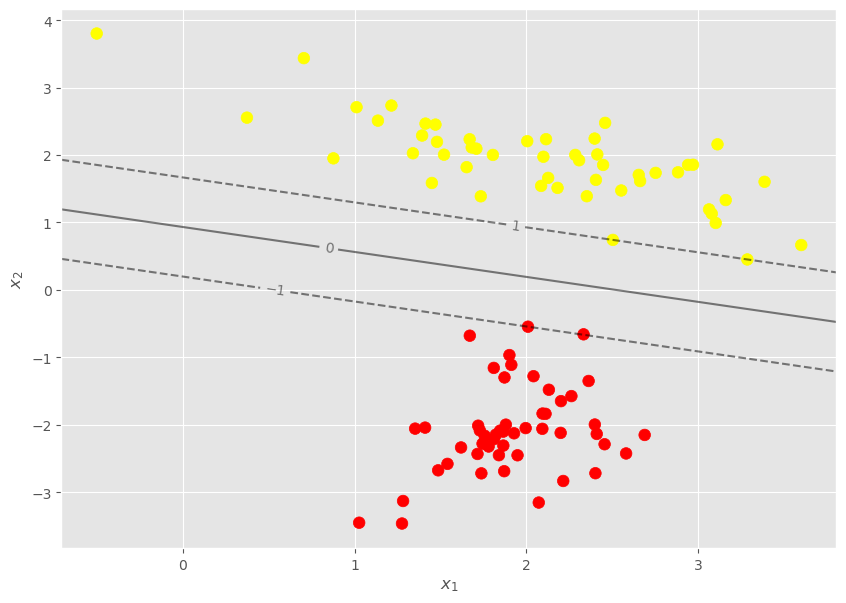

In [11]:
lin_sep_svm_demo_kernel_C(kernel="linear")

Полиномиальное (polynomial): 

$K(x, y) = (\gamma \langle x, y\rangle + с)^d$ 

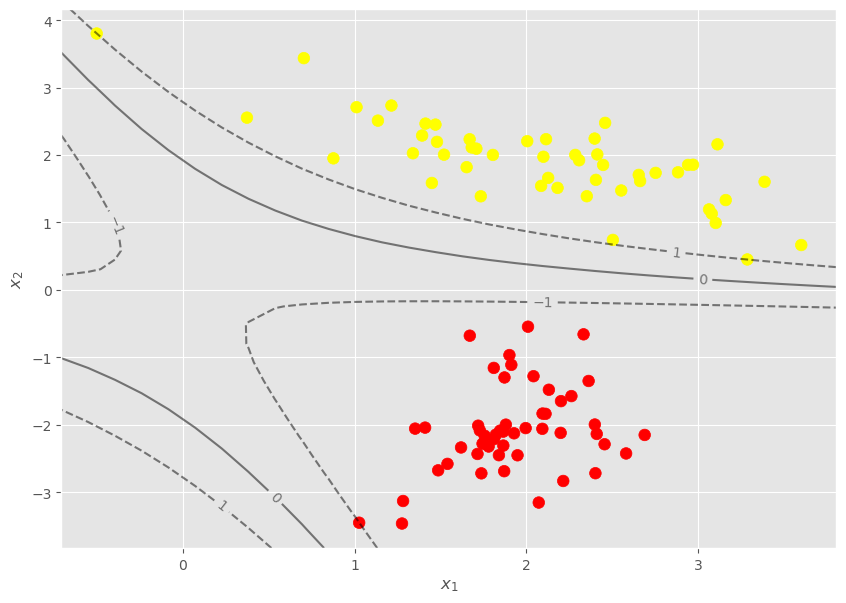

In [12]:
lin_sep_svm_demo_kernel_C(kernel="poly")

Radial basis function kernel (rbf): 

$K(x, y) = e^{(-\gamma  \cdot \|x - y\|^2)}$

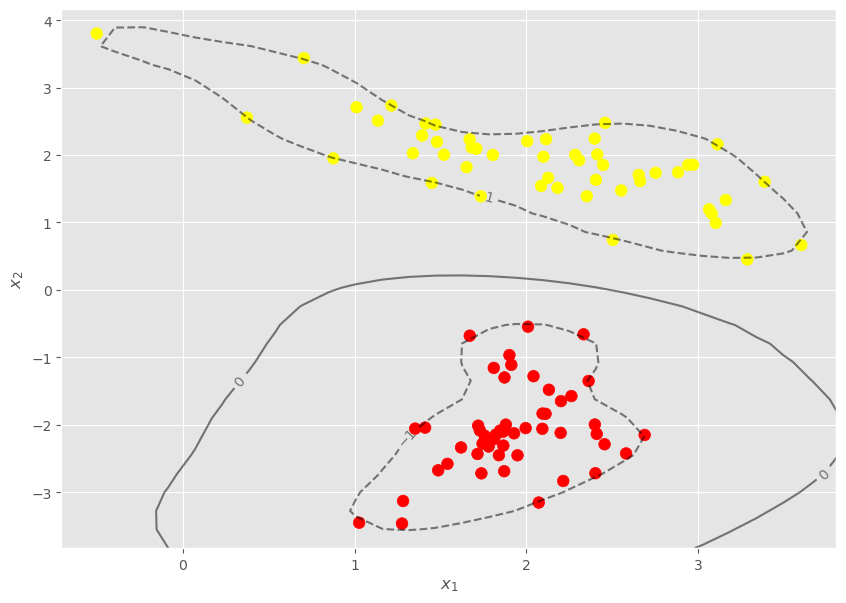

In [13]:
lin_sep_svm_demo_kernel_C(kernel="rbf")

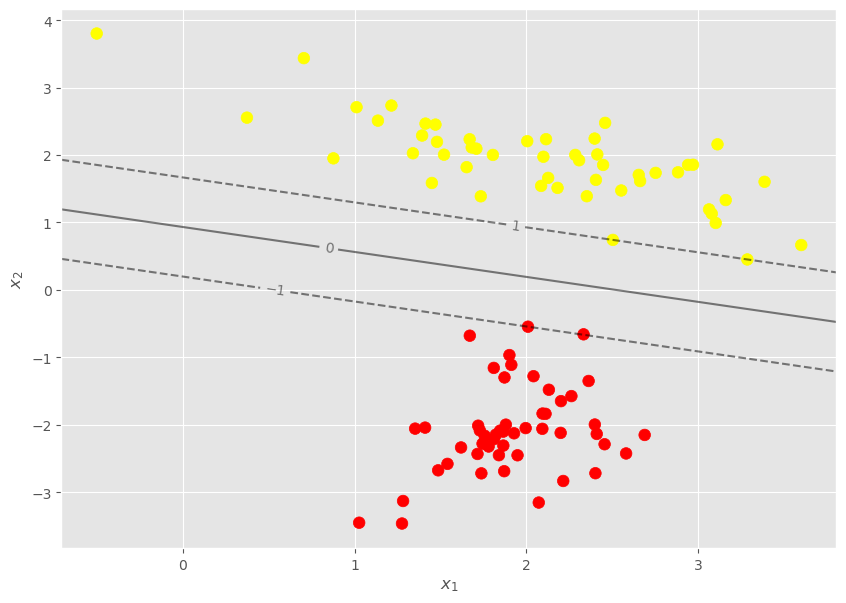

In [14]:
lin_sep_svm_demo_kernel_C(kernel="linear")

# Практика

In [15]:
from pathlib import Path

data_path = Path.cwd().parents[1].joinpath("data", "heart.dat")
data = pd.read_table(data_path, sep=" ", header=None)
data.columns = [
    "age",
    "sex",
    "chest_pain_type",
    "resting_blood_pressure",
    "serum_cholestoral",
    "fasting_blood_sugar",
    "resting_ecg",
    "max_heart_rate",
    "ex_angina",
    "oldpeak_ST",
    "slope_peak_ST",
    "major_vessels",
    "thal",
    "target",
]
data["target"] = data["target"] - 1

In [16]:
data.head()

,age,sex,chest_pain_type,resting_blood_pressure,serum_cholestoral,fasting_blood_sugar,resting_ecg,max_heart_rate,ex_angina,oldpeak_ST,slope_peak_ST,major_vessels,thal,target
0,70.0,1.0,4.0,130.0,322.0,0.0,2.0,109.0,0.0,2.4,2.0,3.0,3.0,1
1,67.0,0.0,3.0,115.0,564.0,0.0,2.0,160.0,0.0,1.6,2.0,0.0,7.0,0
2,57.0,1.0,2.0,124.0,261.0,0.0,0.0,141.0,0.0,0.3,1.0,0.0,7.0,1
3,64.0,1.0,4.0,128.0,263.0,0.0,0.0,105.0,1.0,0.2,2.0,1.0,7.0,0
4,74.0,0.0,2.0,120.0,269.0,0.0,2.0,121.0,1.0,0.2,1.0,1.0,3.0,0


In [17]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 270 entries, 0 to 269
Data columns (total 14 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   age                     270 non-null    float64
 1   sex                     270 non-null    float64
 2   chest_pain_type         270 non-null    float64
 3   resting_blood_pressure  270 non-null    float64
 4   serum_cholestoral       270 non-null    float64
 5   fasting_blood_sugar     270 non-null    float64
 6   resting_ecg             270 non-null    float64
 7   max_heart_rate          270 non-null    float64
 8   ex_angina               270 non-null    float64
 9   oldpeak_ST              270 non-null    float64
 10  slope_peak_ST           270 non-null    float64
 11  major_vessels           270 non-null    float64
 12  thal                    270 non-null    float64
 13  target                  270 non-null    int64  
dtypes: float64(13), int64(1)
memory usage: 29.

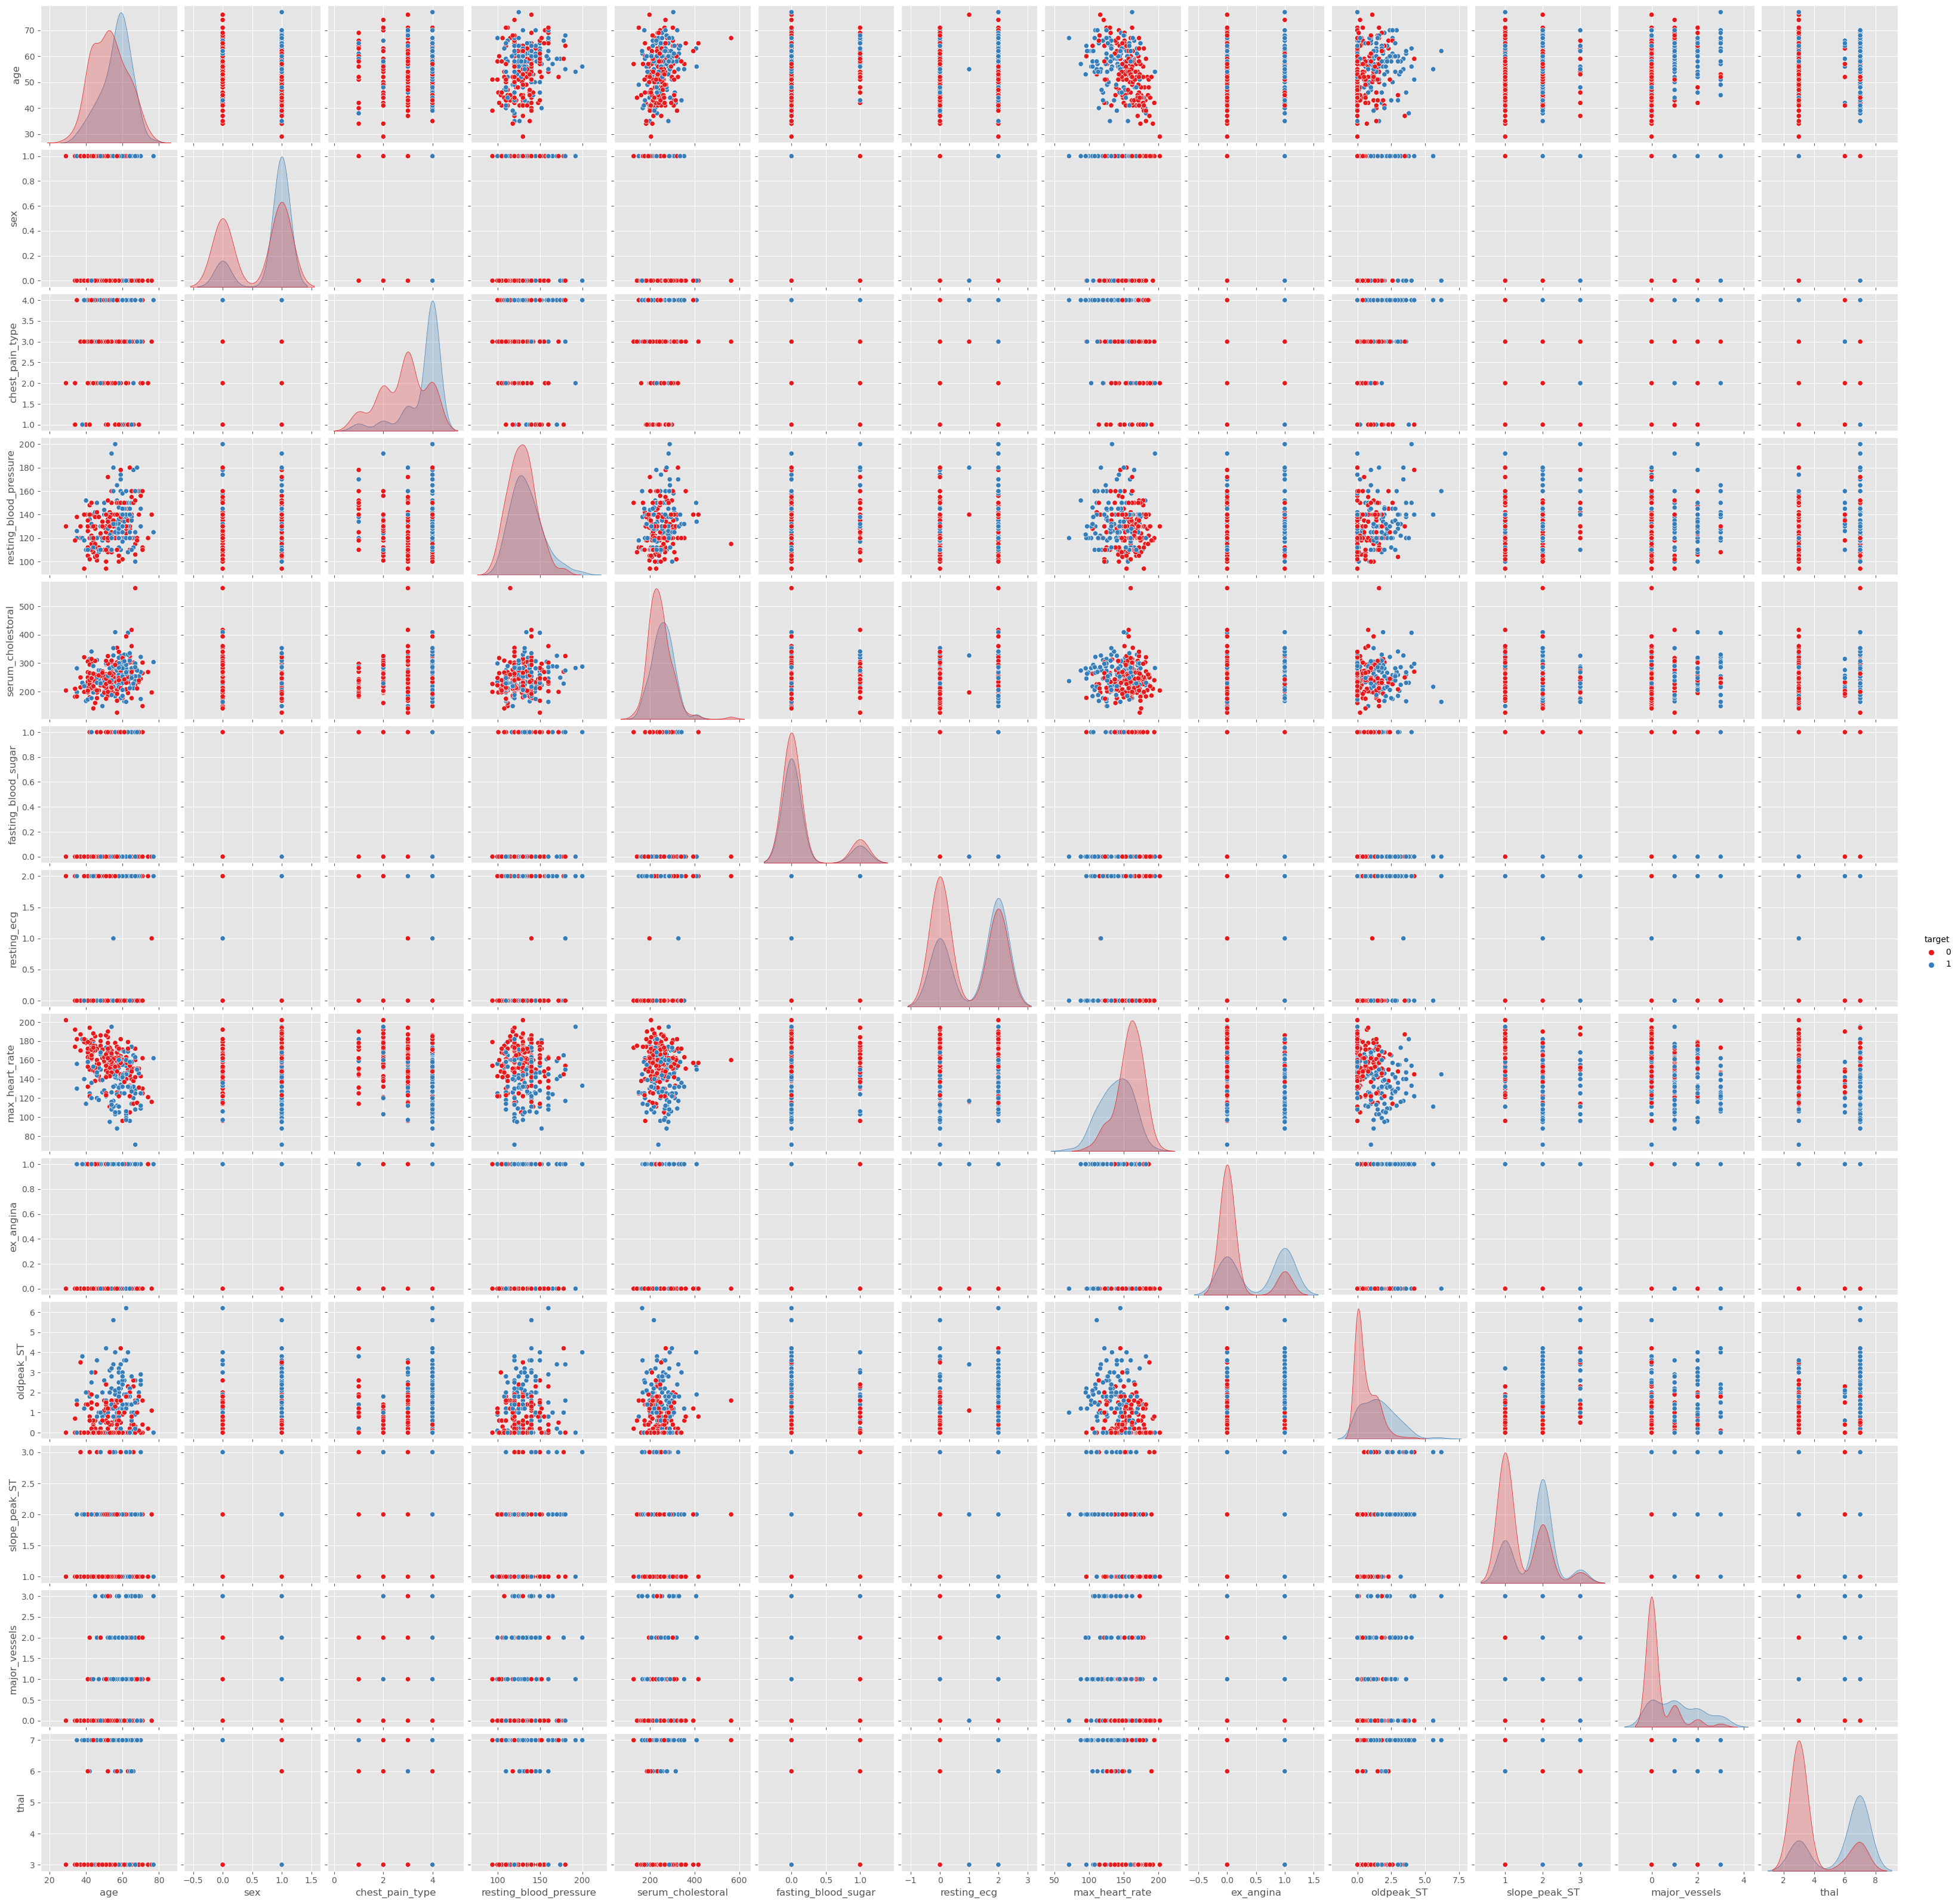

In [18]:
sns.pairplot(data=data, hue="target", palette="Set1")
plt.show()

In [19]:
def quality_report(prediction, actual, verbose=True):
    report_str = (
        "Accuracy: \t {:.3f}\n"
        + "Precision: \t {:.3f}\n"
        + "Recall: \t {:.3f}\n"
        + "f1_score: \t {:.3f}\n"
        + "ROC-AUC: \t {:.3f}"
    )

    acc = accuracy_score(prediction, actual)
    precision = precision_score(prediction, actual)
    recall = recall_score(prediction, actual)
    f1 = f1_score(prediction, actual)
    rocauc = roc_auc_score(prediction, actual)

    quality_list = [acc, precision, recall, f1, rocauc]

    if verbose:
        print("\n=== Quality Report ===")
        print(
            report_str.format(
                accuracy_score(prediction, actual),
                precision_score(prediction, actual),
                recall_score(prediction, actual),
                f1_score(prediction, actual),
                roc_auc_score(prediction, actual),
            )
        )
        print("======================\n")

    return quality_list

In [20]:
data.describe()

,age,sex,chest_pain_type,resting_blood_pressure,serum_cholestoral,fasting_blood_sugar,resting_ecg,max_heart_rate,ex_angina,oldpeak_ST,slope_peak_ST,major_vessels,thal,target
count,270.000000,270.000000,270.000000,270.000000,270.000000,270.000000,270.000000,270.000000,270.000000,270.00000,270.000000,270.000000,270.000000,270.000000
mean,54.433333,0.677778,3.174074,131.344444,249.659259,0.148148,1.022222,149.677778,0.329630,1.05000,1.585185,0.670370,4.696296,0.444444
std,9.109067,0.468195,0.950090,17.861608,51.686237,0.355906,0.997891,23.165717,0.470952,1.14521,0.614390,0.943896,1.940659,0.497827
min,29.000000,0.000000,1.000000,94.000000,126.000000,0.000000,0.000000,71.000000,0.000000,0.00000,1.000000,0.000000,3.000000,0.000000
25%,48.000000,0.000000,3.000000,120.000000,213.000000,0.000000,0.000000,133.000000,0.000000,0.00000,1.000000,0.000000,3.000000,0.000000
50%,55.000000,1.000000,3.000000,130.000000,245.000000,0.000000,2.000000,153.500000,0.000000,0.80000,2.000000,0.000000,3.000000,0.000000
75%,61.000000,1.000000,4.000000,140.000000,280.000000,0.000000,2.000000,166.000000,1.000000,1.60000,2.000000,1.000000,7.000000,1.000000
max,77.000000,1.000000,4.000000,200.000000,564.000000,1.000000,2.000000,202.000000,1.000000,6.20000,3.000000,3.000000,7.000000,1.000000


In [21]:
X_train, X_test, y_train, y_test = train_test_split(
    data.drop(labels=["target"], axis=1),
    data["target"],
    test_size=0.3,
    stratify=data["target"],
    random_state=0,
)

scaler = MinMaxScaler()
scaler.fit(X_train)

X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [22]:
model_LogR = LogisticRegression()
model_LogR.fit(X_train_scaled, y_train)
pred_LR = model_LogR.predict(X_test_scaled)

In [23]:
qr_lr = quality_report(pred_LR, y_test.values)


=== Quality Report ===
Accuracy: 	 0.827
Precision: 	 0.778
Recall: 	 0.824
f1_score: 	 0.800
ROC-AUC: 	 0.827



In [24]:
model_svc = svm.SVC()
model_svc.fit(X_train_scaled, y_train)
pred_svc = model_svc.predict(X_test_scaled)

In [25]:
qr_svc = quality_report(pred_svc, y_test.values)


=== Quality Report ===
Accuracy: 	 0.840
Precision: 	 0.778
Recall: 	 0.848
f1_score: 	 0.812
ROC-AUC: 	 0.841



# Ссылки и ресурсы

University of Waterloo:

* https://www.youtube.com/watch?v=SHBFk1ULNlE&list=PLehuLRPyt1HzXDemu7K4ETcF0Ld_B5adG&index=8
* https://www.youtube.com/watch?v=rLT4OFy-atc&list=PLehuLRPyt1HzXDemu7K4ETcF0Ld_B5adG&index=9
* https://www.youtube.com/watch?v=iZ3HF2_vF2c&list=PLehuLRPyt1HzXDemu7K4ETcF0Ld_B5adG&index=10

Stanford course - Mining Massive Datasets:

* https://www.youtube.com/watch?v=v7H5ks5iDEQ&list=PLLssT5z_DsK9JDLcT8T62VtzwyW9LNepV&index=67
* https://www.youtube.com/watch?v=ax8LxRZCORU&list=PLLssT5z_DsK9JDLcT8T62VtzwyW9LNepV&index=68
* https://www.youtube.com/watch?v=bS1avoD6g8s&list=PLLssT5z_DsK9JDLcT8T62VtzwyW9LNepV&index=69
* https://www.youtube.com/watch?v=8xbnLHn4jjQ&list=PLLssT5z_DsK9JDLcT8T62VtzwyW9LNepV&index=70
* https://www.youtube.com/watch?v=rB-iRIpAPKo&list=PLLssT5z_DsK9JDLcT8T62VtzwyW9LNepV&index=71

MIT OCW:

* https://www.youtube.com/watch?v=_PwhiWxHK8o
* https://www.youtube.com/watch?v=6nDqY8MPLDM

Articles:

* https://towardsdatascience.com/support-vector-machines-for-classification-fc7c1565e3
* https://medium.com/@saishruthi.tn/support-vector-machine-using-numpy-846f83f4183d
* https://pythonprogramming.net/support-vector-machine-intro-machine-learning-tutorial/
* https://houxianxu.github.io/2015/04/25/support-vector-machine/
* https://maviccprp.github.io/a-support-vector-machine-in-just-a-few-lines-of-python-code/
* https://delirium-00.livejournal.com/7649.html

Regression:

* https://www.mathworks.com/help/stats/understanding-support-vector-machine-regression.html

---